In [178]:
import os
import numpy as np
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
import scipy.io
from tsne import tsne
mat = scipy.io.loadmat('./syndata_10.mat')

In [3]:
mat['adjmat_out'][0,:].shape

(1000,)

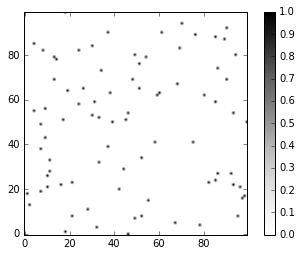

In [13]:
%matplotlib inline
plt.imshow(mat['adjmat_out'][0,:][0], origin='lower', cmap='Greys')
plt.colorbar()

In [17]:
def adjmat2edge(fname, adjmat, weighted=False, graph='directed'):
    """
    Convert adjancent matrix to edge representation.
    """
    with open(fname, 'w') as fp:
        for i in xrange(adjmat.shape[0]):
            for j in xrange(adjmat.shape[1]):
                if graph == 'directed':
                    if adjmat[i,j] > 0:
                        if weighted:
                            fp.write('%i %i %f\n' %(i,j,adjmat[i,j]))
                        else:
                            fp.write('%i %i\n' %(i,j))

In [18]:
adjmat2edge('node2vec/graph/synedge', mat['adjmat_out'][0,:][0])

In [9]:
!python node2vec/src/main.py --help

Using TensorFlow backend.
usage: main.py [-h] [--input [INPUT]] [--output [OUTPUT]]
               [--dimensions DIMENSIONS] [--walk-length WALK_LENGTH]
               [--num-walks NUM_WALKS] [--window-size WINDOW_SIZE]
               [--iter ITER] [--workers WORKERS] [--p P] [--q Q] [--weighted]
               [--unweighted] [--directed] [--undirected]

Run node2vec.

optional arguments:
  -h, --help            show this help message and exit
  --input [INPUT]       Input graph path
  --output [OUTPUT]     Embeddings path
  --dimensions DIMENSIONS
                        Number of dimensions. Default is 128.
  --walk-length WALK_LENGTH
                        Length of walk per source. Default is 80.
  --num-walks NUM_WALKS
                        Number of walks per source. Default is 10.
  --window-size WINDOW_SIZE
                        Context size for optimization. Default is 10.
  --iter ITER           Number of epochs in SGD
  --workers WORKERS     Number of parallel workers. 

In [68]:
!python node2vec/src/main.py --input node2vec/graph/synedge --output node2vec/emb/syn.emd --directed --dimensions 2

Using TensorFlow backend.
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [187]:
def read_emb(fname):
    """
    Read the output files from node2vec/deepwalk.
    """
    res = []
    with open(fname, 'r') as fp:
        line = fp.readline().split()
        nnodes, ndim = int(line[0]), int(line[1])
        for i in xrange(nnodes):
            line = map(float, fp.readline().split())
            res.append([line[i] for i in xrange(ndim+1)])
    return np.array(res)

def emb_labels(emb):
    """
    Plot the latent space.
    """
    plt.scatter(emb[:,1], emb[:,2])
    for label, x, y in emb:
        plt.annotate(
            str(int(label)),
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
def run_walk(fname, dim, dimrdt='PCA'):
    """
    Run node2vec/deepwalk in d latent space
    """
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "hh.emd --p 100 --q 100 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "ll.emd --p 0.01 --q 0.01 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "lh.emd --p 0.01 --q 100 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "hl.emd --p 100 --q 0.01 --dimensions " + str(dim))
    os.system("python node2vec/src/main.py --input node2vec/graph/" + fname + " --output node2vec/emb/" + fname + "11.emd --p 1 --q 1 --dimensions " + str(dim))
    os.system("deepwalk --format edgelist --input node2vec/graph/" + fname + " --output deepwalk/emb/" + fname + "dw.emd --representation-size " + str(dim))
    
    plt.figure(figsize=(12,12))
    plt.subplot(3, 2, 1)
    emb = read_emb("node2vec/emb/" + fname + "hh.emd")
    if dim > 2:
        if dimrdt == 'PCA':
            pca.fit(emb[:,1:])
            X = pca.transform(emb[:,1:])
        elif dimrdt == 'tsne':
            X = tsne(emb[:,1:], 2, dim, 10)
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=100, q=100$')
    plt.subplot(3, 2, 2)
    emb = read_emb("node2vec/emb/" + fname + "ll.emd")
    if dim > 2:
        if dimrdt == 'PCA':
            pca.fit(emb[:,1:])
            X = pca.transform(emb[:,1:])
        elif dimrdt == 'tsne':
            X = tsne(emb[:,1:], 2, dim, 10)
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=0.01, q=0.01$')
    plt.subplot(3, 2, 3)
    emb = read_emb("node2vec/emb/" + fname + "lh.emd")
    if dim > 2:
        if dimrdt == 'PCA':
            pca.fit(emb[:,1:])
            X = pca.transform(emb[:,1:])
        elif dimrdt == 'tsne':
            X = tsne(emb[:,1:], 2, dim, 10)
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=0.01, q=100$')
    plt.subplot(3, 2, 4)
    emb = read_emb("node2vec/emb/" + fname + "hl.emd")
    if dim > 2:
        if dimrdt == 'PCA':
            pca.fit(emb[:,1:])
            X = pca.transform(emb[:,1:])
        elif dimrdt == 'tsne':
            X = tsne(emb[:,1:], 2, dim, 10)
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=100, q=0.01$')
    plt.subplot(3, 2, 5)
    emb = read_emb("node2vec/emb/" + fname + "11.emd")
    if dim > 2:
        if dimrdt == 'PCA':
            pca.fit(emb[:,1:])
            X = pca.transform(emb[:,1:])
        elif dimrdt == 'tsne':
            X = tsne(emb[:,1:], 2, dim, 10)
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('$p=1, q=1$')
    plt.subplot(3, 2, 6)
    emb = read_emb("deepwalk/emb/" + fname + "dw.emd")
    if dim > 2:
        if dimrdt == 'PCA':
            pca.fit(emb[:,1:])
            X = pca.transform(emb[:,1:])
        elif dimrdt == 'tsne':
            X = tsne(emb[:,1:], 2, dim, 10)
        emb_labels(np.hstack((emb[:,0][:,None],X)))
    else:
        emb_labels(emb)
    plt.title('deepwalk')

In [120]:
emb = read_emb('node2vec/emb/syn.emd')

In [122]:
plt.scatter(emb[:,1], emb[:,2])
for label, x, y in emb:
    plt.annotate(
        str(int(label)),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 21
Average degree:   1.8261


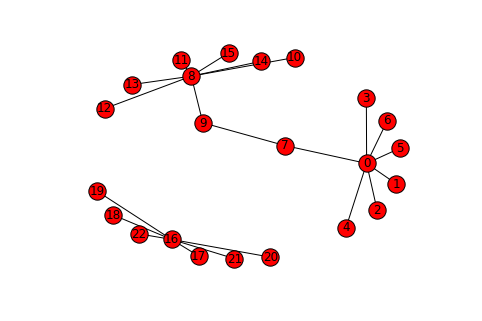

In [181]:
# generate one graph BFS & DFS
%matplotlib inline
ga_edges = pd.read_csv('node2vec/graph/testedge', sep=' ', header=None)
GA = nx.from_pandas_dataframe(ga_edges, source=0, target=1)
print(nx.info(GA))
nx.draw(GA, with_labels=True)

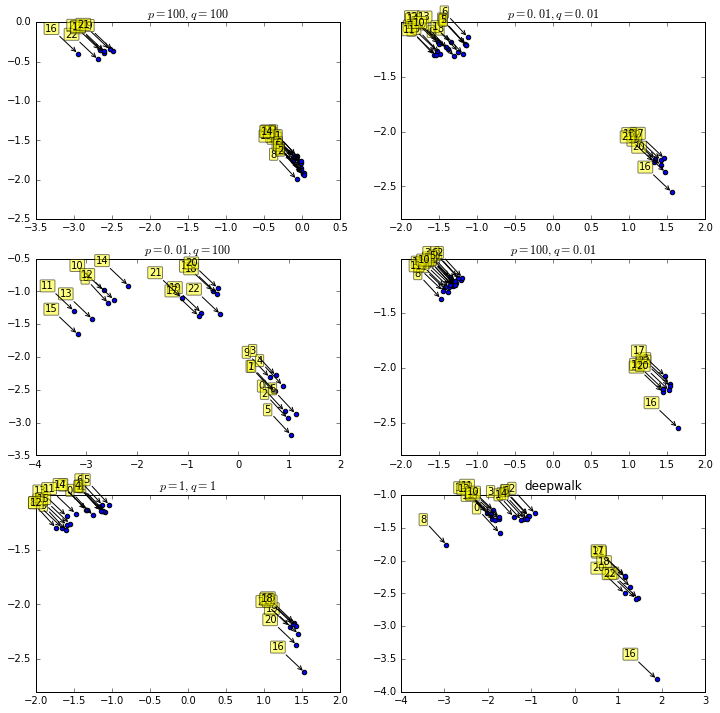

In [182]:
run_walk("testedge", 2)

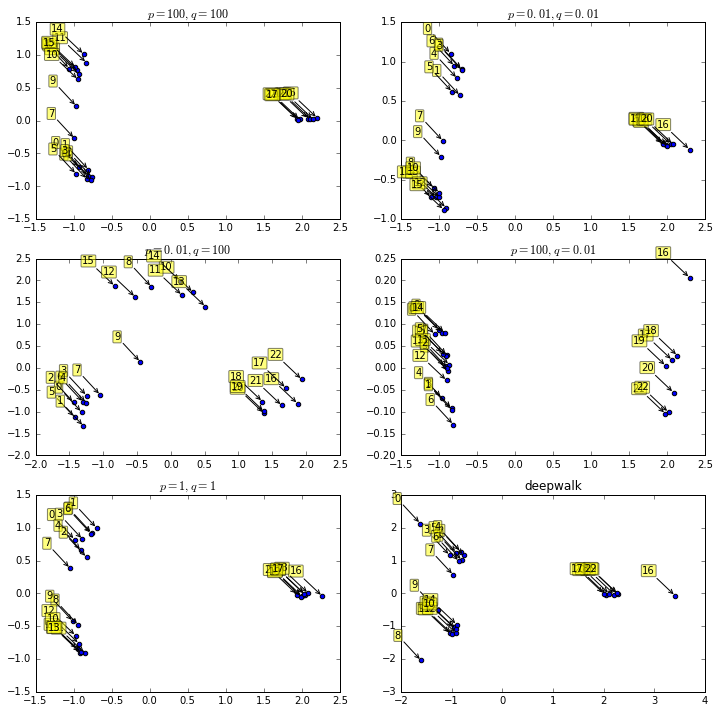

In [183]:
run_walk("testedge", 20)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  23 ...
Mean value of sigma:  1.1282684681
Iteration  10 : error is  11.897822506
Iteration  20 : error is  16.5974049355
Iteration  30 : error is  17.0392396729
Iteration  40 : error is  15.7789547952
Iteration  50 : error is  15.3086877895
Iteration  60 : error is  15.2760439124
Iteration  70 : error is  15.7788551213
Iteration  80 : error is  16.7874557878
Iteration  90 : error is  17.2280047536
Iteration  100 : error is  26.5112068317
Iteration  110 : error is  2.32801517794
Iteration  120 : error is  2.02068743335
Iteration  130 : error is  1.90970231743
Iteration  140 : error is  1.85266498277
Iteration  150 : error is  1.80768272897
Iteration  160 : error is  1.76874310654
Iteration  170 : error is  1.73529990437
Iteration  180 : error is  1.707363949
Iteration  190 : error is  1.68429042907
Iteration  200 : error is  1.66454838476
Iteration  210 : error is  1.64655475067
Iter

Iteration  930 : error is  0.146160559798
Iteration  940 : error is  0.14611715986
Iteration  950 : error is  0.146074146859
Iteration  960 : error is  0.146031503841
Iteration  970 : error is  0.145989209726
Iteration  980 : error is  0.145947241208
Iteration  990 : error is  0.145905576199
Iteration  1000 : error is  0.145864196687
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  23 ...
Mean value of sigma:  1.76616456742
Iteration  10 : error is  12.6673023106
Iteration  20 : error is  14.5671837821
Iteration  30 : error is  14.5211992992
Iteration  40 : error is  16.7636084779
Iteration  50 : error is  14.3609491082
Iteration  60 : error is  14.2290023651
Iteration  70 : error is  13.40367925
Iteration  80 : error is  13.4812372958
Iteration  90 : error is  13.0781680118
Iteration  100 : error is  20.5308007532
Iteration  110 : error is  2.12002684818
Iteration  120 : error is  1.89297375115
Iteration  130 : error is  1.730510

Iteration  940 : error is  0.14392658684
Iteration  950 : error is  0.143881126497
Iteration  960 : error is  0.143838830916
Iteration  970 : error is  0.143799569832
Iteration  980 : error is  0.143763205513
Iteration  990 : error is  0.143729594143
Iteration  1000 : error is  0.143698588752
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  23 ...
Mean value of sigma:  1.25262679891
Iteration  10 : error is  12.0340144641
Iteration  20 : error is  11.9032152066
Iteration  30 : error is  15.1785929875
Iteration  40 : error is  13.4586495092
Iteration  50 : error is  13.6897163574
Iteration  60 : error is  14.0036921607
Iteration  70 : error is  16.6778773279
Iteration  80 : error is  13.4452397188
Iteration  90 : error is  12.869894069
Iteration  100 : error is  14.6283088732
Iteration  110 : error is  1.81288500909
Iteration  120 : error is  1.59460020121
Iteration  130 : error is  1.455518944
Iteration  140 : error is  1.40174855

Iteration  860 : error is  0.176328515255
Iteration  870 : error is  0.174454470544
Iteration  880 : error is  0.172473207512
Iteration  890 : error is  0.170435811407
Iteration  900 : error is  0.168394146917
Iteration  910 : error is  0.166399472267
Iteration  920 : error is  0.164500559519
Iteration  930 : error is  0.162740544629
Iteration  940 : error is  0.16115372203
Iteration  950 : error is  0.159762438281
Iteration  960 : error is  0.158575657657
Iteration  970 : error is  0.157589879885
Iteration  980 : error is  0.156791732061
Iteration  990 : error is  0.156161128544
Iteration  1000 : error is  0.155674348199


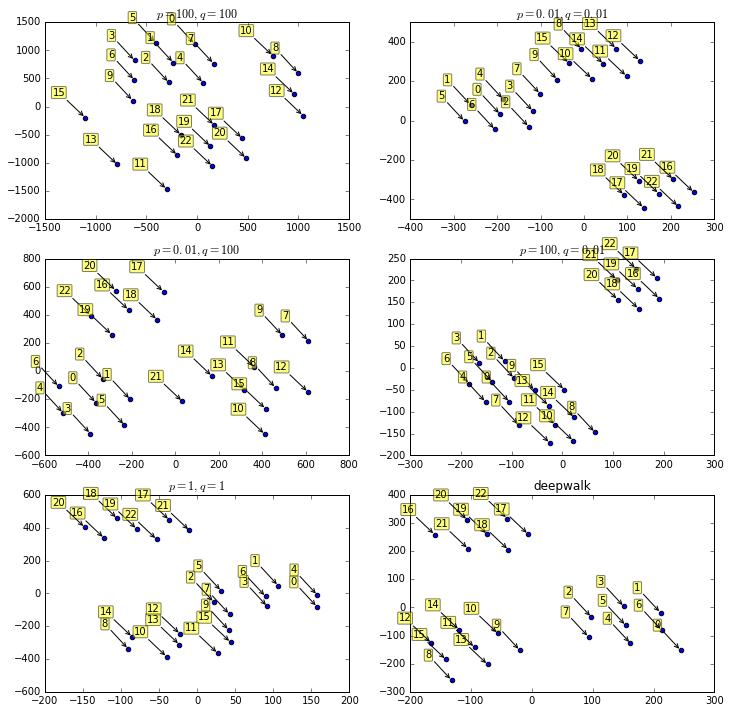

In [188]:
run_walk("testedge", 20, 'tsne')

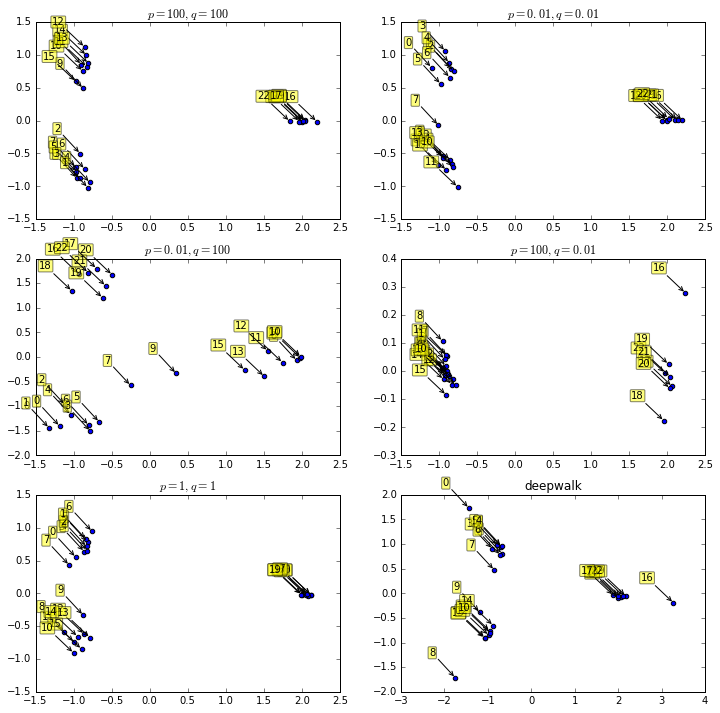

In [185]:
run_walk("testedge", 100)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  23 ...
Mean value of sigma:  1.1560383605
Iteration  10 : error is  13.0851593176
Iteration  20 : error is  12.8939892099
Iteration  30 : error is  11.4389702763
Iteration  40 : error is  11.9178635161
Iteration  50 : error is  12.9713551944
Iteration  60 : error is  12.3974965873
Iteration  70 : error is  14.5228825249
Iteration  80 : error is  12.3317838583
Iteration  90 : error is  20.3280790362
Iteration  100 : error is  12.7815164364
Iteration  110 : error is  1.66120590132
Iteration  120 : error is  1.5460219027
Iteration  130 : error is  1.46578803064
Iteration  140 : error is  1.4112713892
Iteration  150 : error is  1.36234064262
Iteration  160 : error is  1.3189002691
Iteration  170 : error is  1.28617716676
Iteration  180 : error is  1.25953327553
Iteration  190 : error is  1.23319254962
Iteration  200 : error is  1.2041579645
Iteration  210 : error is  1.17901137227
Itera

Iteration  950 : error is  0.15952275425
Iteration  960 : error is  0.15934330748
Iteration  970 : error is  0.159174230964
Iteration  980 : error is  0.159013739297
Iteration  990 : error is  0.158860302382
Iteration  1000 : error is  0.158712732699
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  23 ...
Mean value of sigma:  1.76348722403
Iteration  10 : error is  12.8351775954
Iteration  20 : error is  14.3186009436
Iteration  30 : error is  11.1926733795
Iteration  40 : error is  13.7779165079
Iteration  50 : error is  13.3966179086
Iteration  60 : error is  13.1965249455
Iteration  70 : error is  13.2564157465
Iteration  80 : error is  12.8603328585
Iteration  90 : error is  13.0269968369
Iteration  100 : error is  11.9813178545
Iteration  110 : error is  1.65772581954
Iteration  120 : error is  1.35935707085
Iteration  130 : error is  1.14419089312
Iteration  140 : error is  1.01718452571
Iteration  150 : error is  0.9147361

Iteration  870 : error is  0.75690734773
Iteration  880 : error is  0.748512211766
Iteration  890 : error is  0.740682592145
Iteration  900 : error is  0.733424177694
Iteration  910 : error is  0.726294130302
Iteration  920 : error is  0.718728107383
Iteration  930 : error is  0.710126325425
Iteration  940 : error is  0.699557970917
Iteration  950 : error is  0.6855613998
Iteration  960 : error is  0.666676036981
Iteration  970 : error is  0.645180972541
Iteration  980 : error is  0.626363619913
Iteration  990 : error is  0.605896345193
Iteration  1000 : error is  0.582260027505
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  23 ...
Mean value of sigma:  1.22155428918
Iteration  10 : error is  12.2797879358
Iteration  20 : error is  11.1506295037
Iteration  30 : error is  15.2275380294
Iteration  40 : error is  14.6134059063
Iteration  50 : error is  15.7201872798
Iteration  60 : error is  15.9691146219
Iteration  70 : error is  

Iteration  850 : error is  0.300516308059
Iteration  860 : error is  0.299313435658
Iteration  870 : error is  0.298464846462
Iteration  880 : error is  0.297837868175
Iteration  890 : error is  0.297319952524
Iteration  900 : error is  0.296874798564
Iteration  910 : error is  0.296498370822
Iteration  920 : error is  0.296189139918
Iteration  930 : error is  0.295939613438
Iteration  940 : error is  0.295737507033
Iteration  950 : error is  0.295569496182
Iteration  960 : error is  0.295424402196
Iteration  970 : error is  0.295294457373
Iteration  980 : error is  0.295174769136
Iteration  990 : error is  0.295062188551
Iteration  1000 : error is  0.294954521401


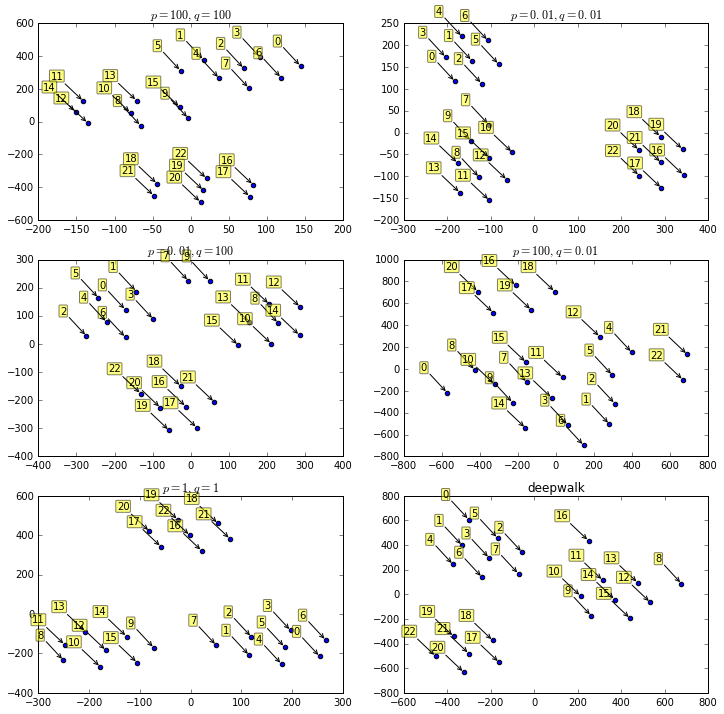

In [189]:
run_walk("testedge", 100, 'tsne')

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 14
Average degree:   2.0000


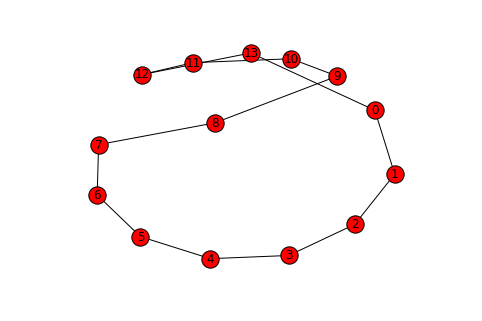

In [190]:
# generate one graph BFS & DFS
circ_edges = pd.read_csv('node2vec/graph/circular', sep=' ', header=None)
GC = nx.from_pandas_dataframe(circ_edges, source=0, target=1)
print(nx.info(GC))
nx.draw(GC, with_labels=True)

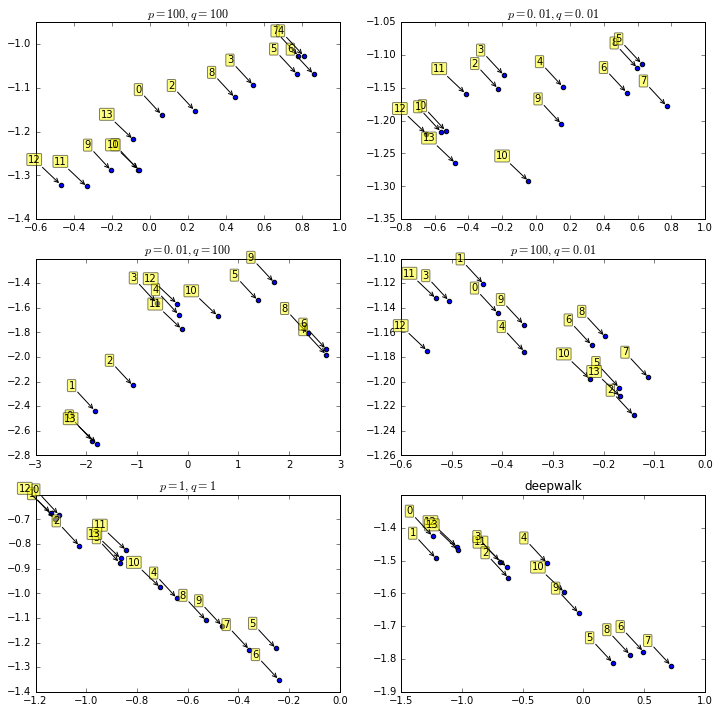

In [191]:
run_walk("circular", 2)

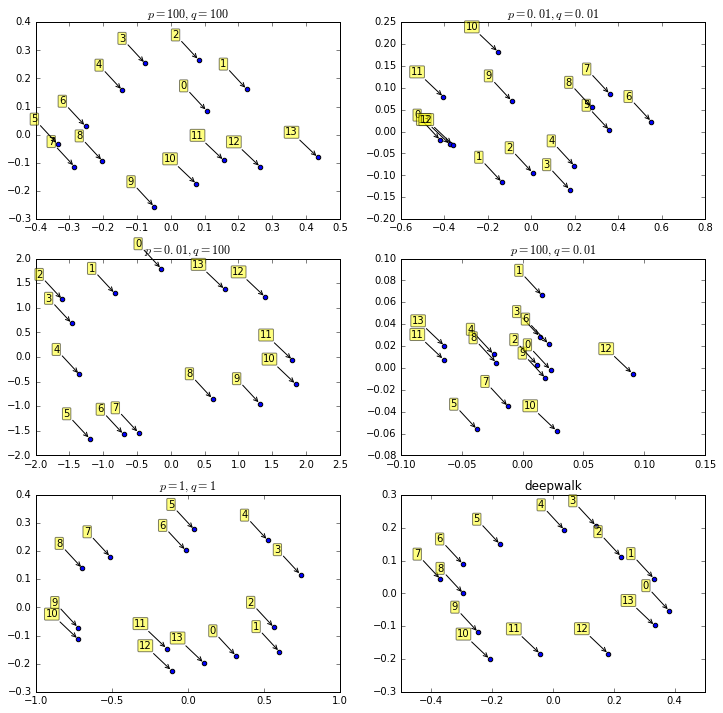

In [192]:
run_walk("circular", 20)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14 ...
Mean value of sigma:  0.453108894909
Iteration  10 : error is  9.21815655489
Iteration  20 : error is  11.8808594366
Iteration  30 : error is  10.1016617541
Iteration  40 : error is  12.5279524537
Iteration  50 : error is  11.4758522923
Iteration  60 : error is  12.8888823552
Iteration  70 : error is  13.3075592545
Iteration  80 : error is  13.090146745
Iteration  90 : error is  13.5192696242
Iteration  100 : error is  14.0874323924
Iteration  110 : error is  1.27079017596
Iteration  120 : error is  0.851744699571
Iteration  130 : error is  0.695653517763
Iteration  140 : error is  0.622469202803
Iteration  150 : error is  0.575352038282
Iteration  160 : error is  0.552642701315
Iteration  170 : error is  0.543885828996
Iteration  180 : error is  0.538372309328
Iteration  190 : error is  0.534202722573
Iteration  200 : error is  0.530875295515
Iteration  210 : error is  0.527

Iteration  980 : error is  0.212762077987
Iteration  990 : error is  0.212130329853
Iteration  1000 : error is  0.211665650465
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14 ...
Mean value of sigma:  2.55168174413
Iteration  10 : error is  8.91787381651
Iteration  20 : error is  11.2097667248
Iteration  30 : error is  12.774550869
Iteration  40 : error is  14.7093516761
Iteration  50 : error is  12.0562754767
Iteration  60 : error is  14.4919640966
Iteration  70 : error is  14.8946769014
Iteration  80 : error is  11.4370663507
Iteration  90 : error is  11.7928346746
Iteration  100 : error is  18.3083729965
Iteration  110 : error is  1.36397595904
Iteration  120 : error is  0.850179405909
Iteration  130 : error is  0.70121459716
Iteration  140 : error is  0.65260986355
Iteration  150 : error is  0.628828118571
Iteration  160 : error is  0.608396874239
Iteration  170 : error is  0.586131034397
Iteration  180 : error is  0.56528

Iteration  980 : error is  0.275372178706
Iteration  990 : error is  0.275371109456
Iteration  1000 : error is  0.275370290126
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14 ...
Mean value of sigma:  0.5657540823
Iteration  10 : error is  9.91170847246
Iteration  20 : error is  9.9506783279
Iteration  30 : error is  8.8379195535
Iteration  40 : error is  11.1544773456
Iteration  50 : error is  12.6600457536
Iteration  60 : error is  10.4775109887
Iteration  70 : error is  11.9457325284
Iteration  80 : error is  13.2172552883
Iteration  90 : error is  13.2536880276
Iteration  100 : error is  12.1842062741
Iteration  110 : error is  1.41692953171
Iteration  120 : error is  1.278516786
Iteration  130 : error is  1.18376291721
Iteration  140 : error is  1.09310611425
Iteration  150 : error is  1.01338666536
Iteration  160 : error is  0.943201785089
Iteration  170 : error is  0.880912067275
Iteration  180 : error is  0.82641730133

Iteration  960 : error is  0.182348031817
Iteration  970 : error is  0.181814363379
Iteration  980 : error is  0.1813089933
Iteration  990 : error is  0.180832117538
Iteration  1000 : error is  0.180382123488


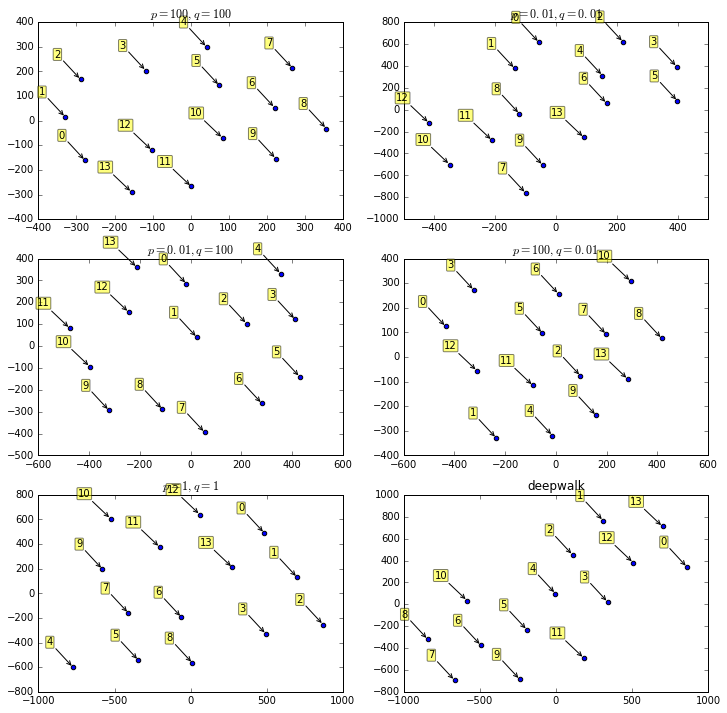

In [193]:
run_walk("circular", 20, 'tsne')

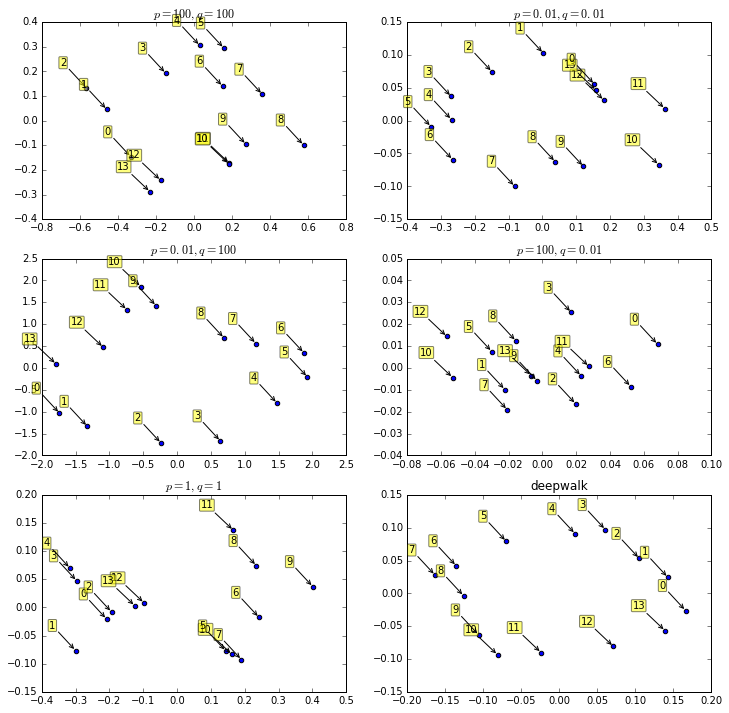

In [194]:
run_walk("circular", 100)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14 ...
Mean value of sigma:  0.314888982555
Iteration  10 : error is  9.42007038428
Iteration  20 : error is  9.65860877538
Iteration  30 : error is  13.4108052616
Iteration  40 : error is  15.0500903619
Iteration  50 : error is  18.0166423386
Iteration  60 : error is  14.277633041
Iteration  70 : error is  12.7064931803
Iteration  80 : error is  12.1884067433
Iteration  90 : error is  12.3204095442
Iteration  100 : error is  13.6478704997
Iteration  110 : error is  1.55153091159
Iteration  120 : error is  1.26286619347
Iteration  130 : error is  1.07054694589
Iteration  140 : error is  0.943227150987
Iteration  150 : error is  0.842829310382
Iteration  160 : error is  0.743089092635
Iteration  170 : error is  0.650360772021
Iteration  180 : error is  0.577267680299
Iteration  190 : error is  0.522530298053
Iteration  200 : error is  0.480468105971
Iteration  210 : error is  0.44698

Iteration  910 : error is  0.171060102655
Iteration  920 : error is  0.170850176654
Iteration  930 : error is  0.170645874224
Iteration  940 : error is  0.170447293008
Iteration  950 : error is  0.170253849278
Iteration  960 : error is  0.170064320778
Iteration  970 : error is  0.16987696008
Iteration  980 : error is  0.169689665638
Iteration  990 : error is  0.169500114421
Iteration  1000 : error is  0.169305947319
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14 ...
Mean value of sigma:  2.49009024838
Iteration  10 : error is  10.283853811
Iteration  20 : error is  14.4031508444
Iteration  30 : error is  13.00939891
Iteration  40 : error is  12.7345640602
Iteration  50 : error is  13.3903525913
Iteration  60 : error is  13.8830636332
Iteration  70 : error is  16.2608137811
Iteration  80 : error is  10.6162831802
Iteration  90 : error is  8.79689148813
Iteration  100 : error is  8.57792572784
Iteration  110 : error is  0.66674

Iteration  960 : error is  0.209538715759
Iteration  970 : error is  0.207869206324
Iteration  980 : error is  0.206330363637
Iteration  990 : error is  0.204839362417
Iteration  1000 : error is  0.203340700339
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  14 ...
Mean value of sigma:  0.428168835984
Iteration  10 : error is  9.59235245719
Iteration  20 : error is  13.9870390973
Iteration  30 : error is  8.66135326799
Iteration  40 : error is  8.81185192011
Iteration  50 : error is  9.44292744417
Iteration  60 : error is  10.1806183597
Iteration  70 : error is  12.778883426
Iteration  80 : error is  10.2751405296
Iteration  90 : error is  10.1894591731
Iteration  100 : error is  10.1782272023
Iteration  110 : error is  0.962955936314
Iteration  120 : error is  0.717285424138
Iteration  130 : error is  0.582194096357
Iteration  140 : error is  0.52758683284
Iteration  150 : error is  0.486717592641
Iteration  160 : error is  0.45

Iteration  930 : error is  0.208837546525
Iteration  940 : error is  0.203016862105
Iteration  950 : error is  0.196620278161
Iteration  960 : error is  0.190257922203
Iteration  970 : error is  0.185358445626
Iteration  980 : error is  0.183156550022
Iteration  990 : error is  0.18234643016
Iteration  1000 : error is  0.181671365279


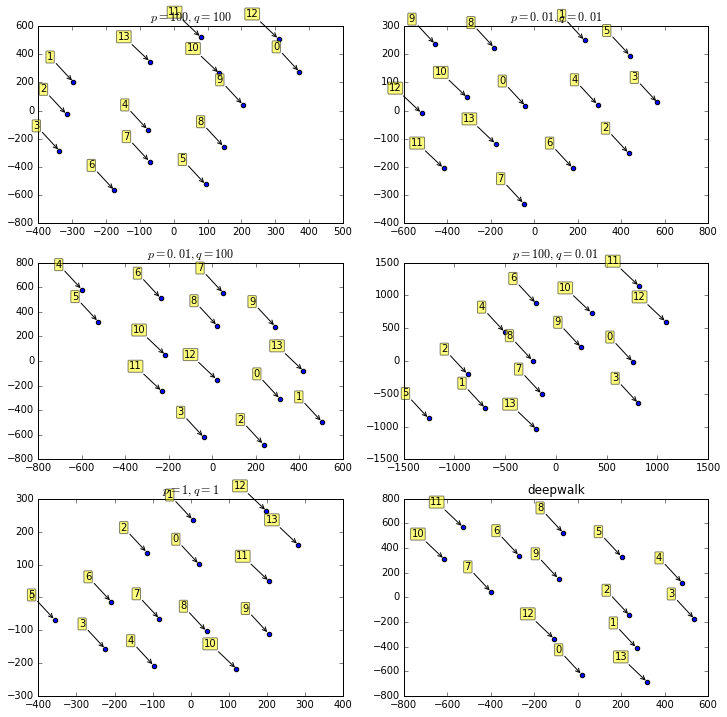

In [195]:
run_walk("circular", 100, 'tsne')

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 10
Average degree:   2.0000


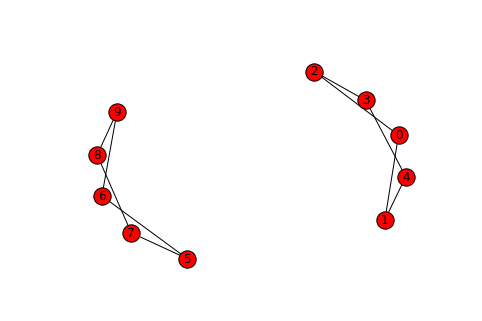

In [196]:
# generate one graph BFS & DFS
circ_edges = pd.read_csv('node2vec/graph/star', sep=' ', header=None)
GC = nx.from_pandas_dataframe(circ_edges, source=0, target=1)
print(nx.info(GC))
nx.draw(GC, with_labels=True)

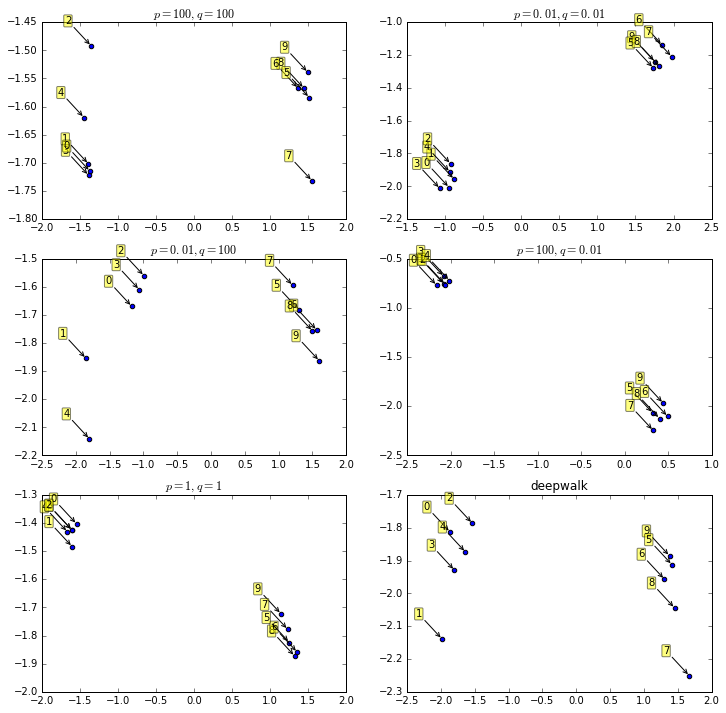

In [197]:
run_walk("star", 2)

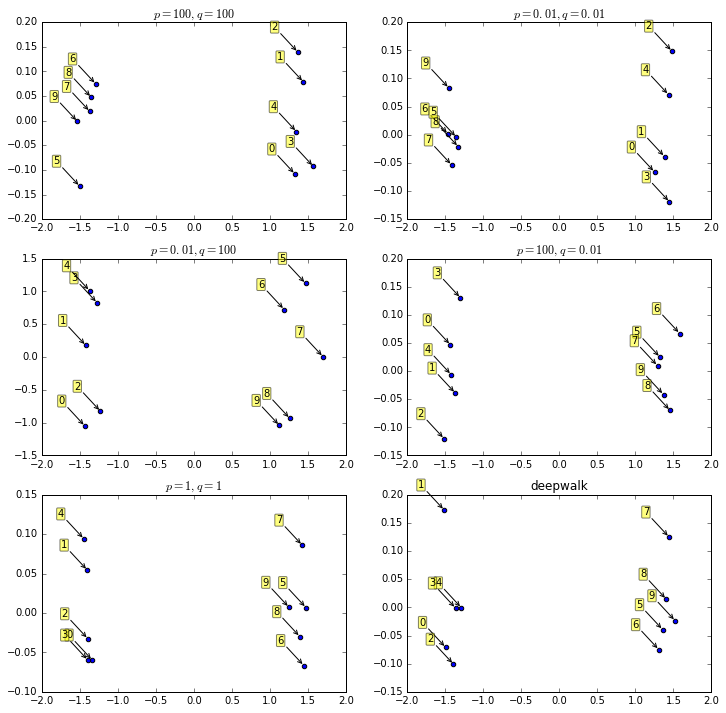

In [198]:
run_walk("star", 20)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  10 ...
Mean value of sigma:  33554432.0
Iteration  10 : error is  8.03076520381
Iteration  20 : error is  8.66961128979
Iteration  30 : error is  9.47556937405
Iteration  40 : error is  9.07185465379
Iteration  50 : error is  8.81964453183
Iteration  60 : error is  10.0055875536
Iteration  70 : error is  13.6281638272
Iteration  80 : error is  11.2336304219
Iteration  90 : error is  11.7204112857
Iteration  100 : error is  11.6536858696
Iteration  110 : error is  1.45267295124
Iteration  120 : error is  1.34182590465
Iteration  130 : error is  1.21884320313
Iteration  140 : error is  1.09244755959
Iteration  150 : error is  0.975748145837
Iteration  160 : error is  0.875170211326
Iteration  170 : error is  0.790436421258
Iteration  180 : error is  0.719948317276
Iteration  190 : error is  0.662327997487
Iteration  200 : error is  0.615604404638
Iteration  210 : error is  0.577178218

Iteration  920 : error is  0.252151980614
Iteration  930 : error is  0.252118277743
Iteration  940 : error is  0.252088482179
Iteration  950 : error is  0.252062481658
Iteration  960 : error is  0.25204007998
Iteration  970 : error is  0.25202101566
Iteration  980 : error is  0.252004982283
Iteration  990 : error is  0.251991648548
Iteration  1000 : error is  0.251980676328
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  10 ...
Mean value of sigma:  33554432.0
Iteration  10 : error is  7.53365467812
Iteration  20 : error is  7.50597283386
Iteration  30 : error is  10.4864573729
Iteration  40 : error is  11.4895485821
Iteration  50 : error is  14.253840284
Iteration  60 : error is  11.270405635
Iteration  70 : error is  10.5712052452
Iteration  80 : error is  10.3652058876
Iteration  90 : error is  10.5823426947
Iteration  100 : error is  11.8668834928
Iteration  110 : error is  1.57864106043
Iteration  120 : error is  0.934857007

Iteration  920 : error is  0.251208152626
Iteration  930 : error is  0.251172950943
Iteration  940 : error is  0.251139425183
Iteration  950 : error is  0.251107719261
Iteration  960 : error is  0.251077949202
Iteration  970 : error is  0.251050200347
Iteration  980 : error is  0.251024525729
Iteration  990 : error is  0.251000945701
Iteration  1000 : error is  0.250979448849
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  10 ...
Mean value of sigma:  33554432.0
Iteration  10 : error is  7.92718609723
Iteration  20 : error is  10.0122684845
Iteration  30 : error is  9.74174316503
Iteration  40 : error is  12.0076847559
Iteration  50 : error is  9.05639434191
Iteration  60 : error is  8.68044620013
Iteration  70 : error is  8.21057731815
Iteration  80 : error is  8.14644267956
Iteration  90 : error is  8.31783662062
Iteration  100 : error is  10.4984000899
Iteration  110 : error is  0.567772469881
Iteration  120 : error is  0.3873

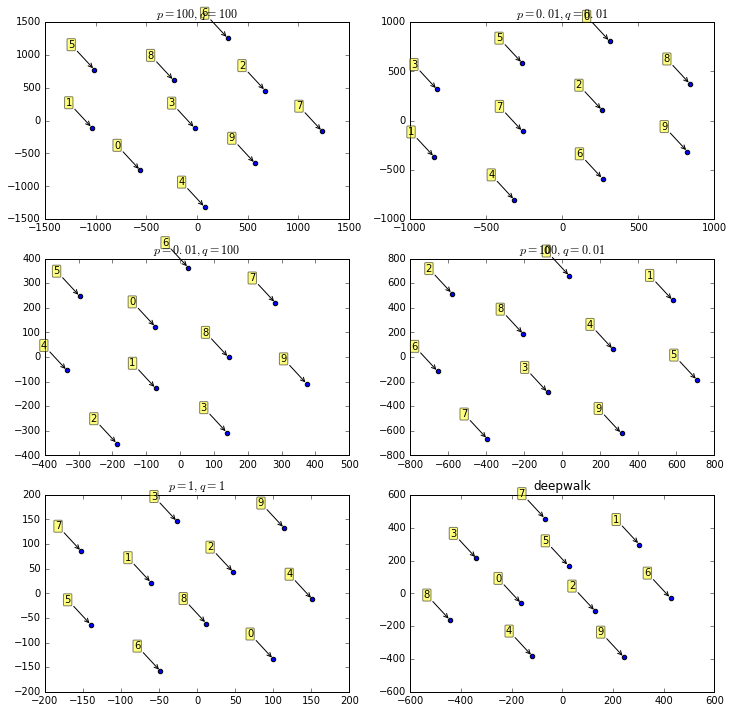

In [199]:
run_walk("star", 20, 'tsne')

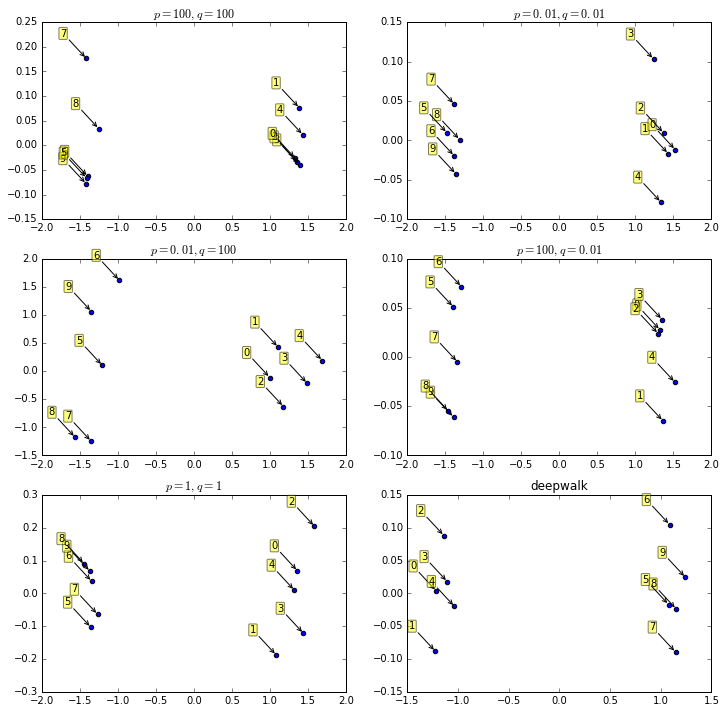

In [200]:
run_walk("star", 100)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  10 ...
Mean value of sigma:  33554432.0
Iteration  10 : error is  8.25807979876
Iteration  20 : error is  7.92006803229
Iteration  30 : error is  9.49894055746
Iteration  40 : error is  7.83946004756
Iteration  50 : error is  7.77616858116
Iteration  60 : error is  7.76417636912
Iteration  70 : error is  7.76035400509
Iteration  80 : error is  7.77785798724
Iteration  90 : error is  7.91130615418
Iteration  100 : error is  8.36649100017
Iteration  110 : error is  0.78942296994
Iteration  120 : error is  0.750394704949
Iteration  130 : error is  0.706549528092
Iteration  140 : error is  0.6605194246
Iteration  150 : error is  0.612508016488
Iteration  160 : error is  0.56121636397
Iteration  170 : error is  0.50603673431
Iteration  180 : error is  0.44945818512
Iteration  190 : error is  0.394119590559
Iteration  200 : error is  0.342719199095
Iteration  210 : error is  0.30317449109

Iteration  1000 : error is  0.252060272569
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  10 ...
Mean value of sigma:  33554432.0
Iteration  10 : error is  7.53472066607
Iteration  20 : error is  8.21065933101
Iteration  30 : error is  8.97839667559
Iteration  40 : error is  8.69702110491
Iteration  50 : error is  8.70411237324
Iteration  60 : error is  8.83537840861
Iteration  70 : error is  9.08238095696
Iteration  80 : error is  10.7472557204
Iteration  90 : error is  10.4357439122
Iteration  100 : error is  13.0792829023
Iteration  110 : error is  1.83383742341
Iteration  120 : error is  1.0898672959
Iteration  130 : error is  0.793067384006
Iteration  140 : error is  0.652982681148
Iteration  150 : error is  0.589596566928
Iteration  160 : error is  0.556071649371
Iteration  170 : error is  0.526144286548
Iteration  180 : error is  0.495517982267
Iteration  190 : error is  0.464338824949
Iteration  200 : error is  0.4330406

Computing pairwise distances...
Computing P-values for point  0  of  10 ...
Mean value of sigma:  33554432.0
Iteration  10 : error is  7.44130965645
Iteration  20 : error is  7.32314714319
Iteration  30 : error is  9.32691448332
Iteration  40 : error is  9.19793838968
Iteration  50 : error is  9.12385725989
Iteration  60 : error is  9.26466817499
Iteration  70 : error is  9.8930028973
Iteration  80 : error is  12.0501674667
Iteration  90 : error is  11.2867481691
Iteration  100 : error is  11.3236168065
Iteration  110 : error is  0.886601213718
Iteration  120 : error is  0.633288055356
Iteration  130 : error is  0.532755699719
Iteration  140 : error is  0.477613653476
Iteration  150 : error is  0.441836605189
Iteration  160 : error is  0.417439711698
Iteration  170 : error is  0.400404061124
Iteration  180 : error is  0.38824448286
Iteration  190 : error is  0.378983858855
Iteration  200 : error is  0.371260601957
Iteration  210 : error is  0.364494098761
Iteration  220 : error is  0.3

Iteration  940 : error is  0.251934147532
Iteration  950 : error is  0.251934147389
Iteration  960 : error is  0.251934147289
Iteration  970 : error is  0.251934147216
Iteration  980 : error is  0.251934147159
Iteration  990 : error is  0.251934147113
Iteration  1000 : error is  0.251934147072


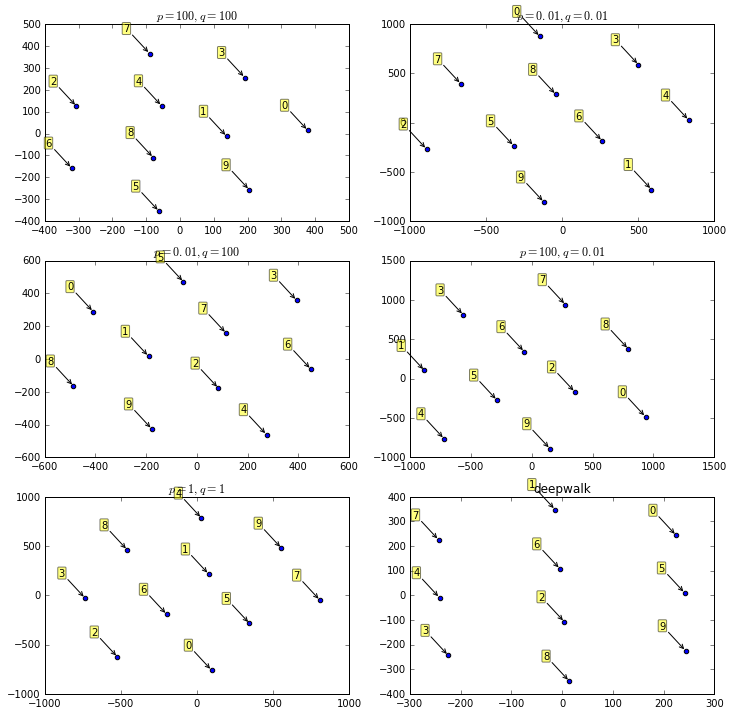

In [201]:
run_walk("star", 100, 'tsne')

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 16
Average degree:   2.1333


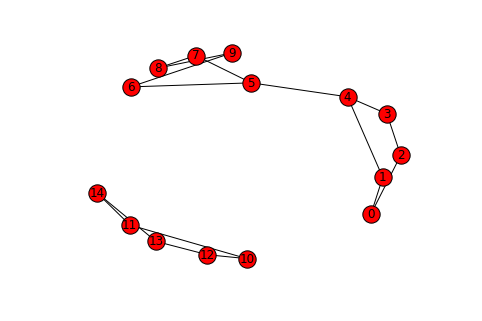

In [202]:
# generate one graph BFS & DFS
circ_edges = pd.read_csv('node2vec/graph/star2', sep=' ', header=None)
GC = nx.from_pandas_dataframe(circ_edges, source=0, target=1)
print(nx.info(GC))
nx.draw(GC, with_labels=True)

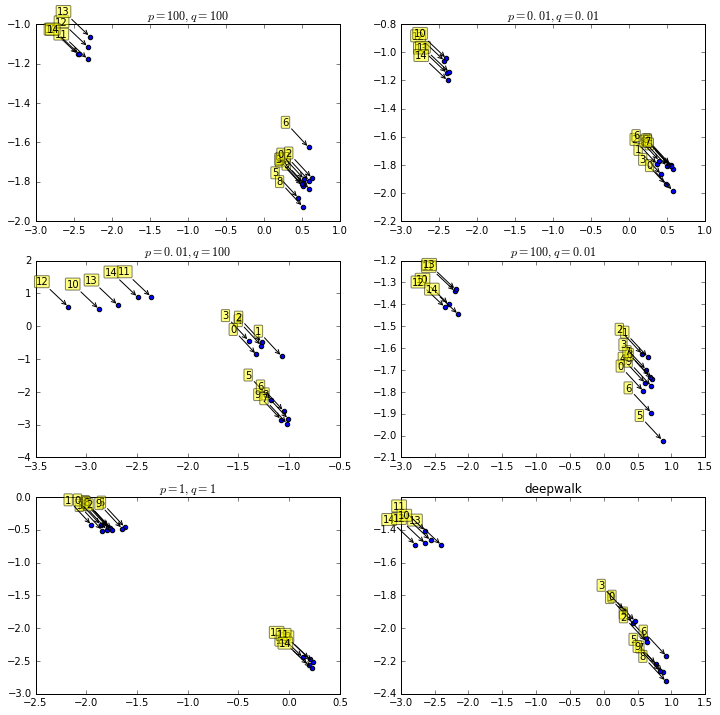

In [203]:
run_walk("star2", 2)

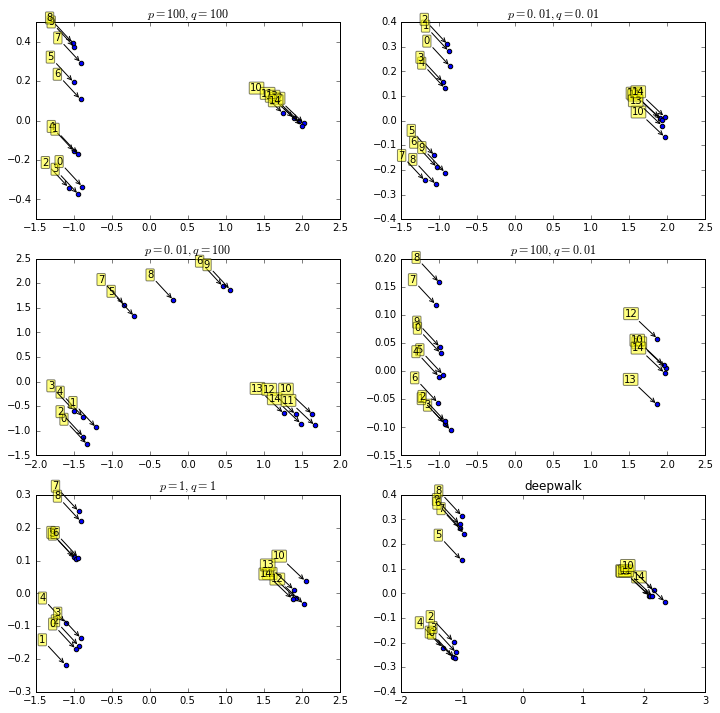

In [204]:
run_walk("star2", 20)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  15 ...
Mean value of sigma:  1.88932827824
Iteration  10 : error is  9.96078629647
Iteration  20 : error is  10.2346478308
Iteration  30 : error is  10.5602689003
Iteration  40 : error is  10.467404455
Iteration  50 : error is  10.6206443128
Iteration  60 : error is  10.9839817223
Iteration  70 : error is  13.1836587606
Iteration  80 : error is  13.5001422724
Iteration  90 : error is  10.3214648461
Iteration  100 : error is  11.9814415704
Iteration  110 : error is  0.89277558922
Iteration  120 : error is  0.724180461671
Iteration  130 : error is  0.63967283967
Iteration  140 : error is  0.601305640328
Iteration  150 : error is  0.581340316486
Iteration  160 : error is  0.566674925155
Iteration  170 : error is  0.556360052834
Iteration  180 : error is  0.550265247304
Iteration  190 : error is  0.545527870318
Iteration  200 : error is  0.540638693577
Iteration  210 : error is  0.53499

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  15 ...
Mean value of sigma:  2.28089589874
Iteration  10 : error is  9.78854127829
Iteration  20 : error is  10.3949203235
Iteration  30 : error is  12.1106270095
Iteration  40 : error is  11.2072921473
Iteration  50 : error is  11.0938378314
Iteration  60 : error is  11.1808040556
Iteration  70 : error is  11.1767101352
Iteration  80 : error is  10.8555854217
Iteration  90 : error is  11.0640020199
Iteration  100 : error is  11.8742191924
Iteration  110 : error is  1.12573264383
Iteration  120 : error is  0.87377884223
Iteration  130 : error is  0.773848508248
Iteration  140 : error is  0.715502873984
Iteration  150 : error is  0.664345136513
Iteration  160 : error is  0.634071858384
Iteration  170 : error is  0.618355780096
Iteration  180 : error is  0.605074340178
Iteration  190 : error is  0.592241799801
Iteration  200 : error is  0.580000400672
Iteration  210 : error is  0.5673

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  15 ...
Mean value of sigma:  1.8619552474
Iteration  10 : error is  9.04015408387
Iteration  20 : error is  11.1770907404
Iteration  30 : error is  10.6848356116
Iteration  40 : error is  10.2340560158
Iteration  50 : error is  12.2692435971
Iteration  60 : error is  10.5199814395
Iteration  70 : error is  11.7755039426
Iteration  80 : error is  16.3486680453
Iteration  90 : error is  11.4289866498
Iteration  100 : error is  12.554479275
Iteration  110 : error is  1.66735699551
Iteration  120 : error is  1.46554021669
Iteration  130 : error is  1.33057216434
Iteration  140 : error is  1.21589892559
Iteration  150 : error is  1.13820233869
Iteration  160 : error is  1.09415311978
Iteration  170 : error is  1.06146765675
Iteration  180 : error is  1.03206183296
Iteration  190 : error is  1.00619868269
Iteration  200 : error is  0.983000527774
Iteration  210 : error is  0.960678106745


Iteration  950 : error is  0.20503780643
Iteration  960 : error is  0.204986153455
Iteration  970 : error is  0.204935685182
Iteration  980 : error is  0.204886566822
Iteration  990 : error is  0.204838945419
Iteration  1000 : error is  0.204792948726


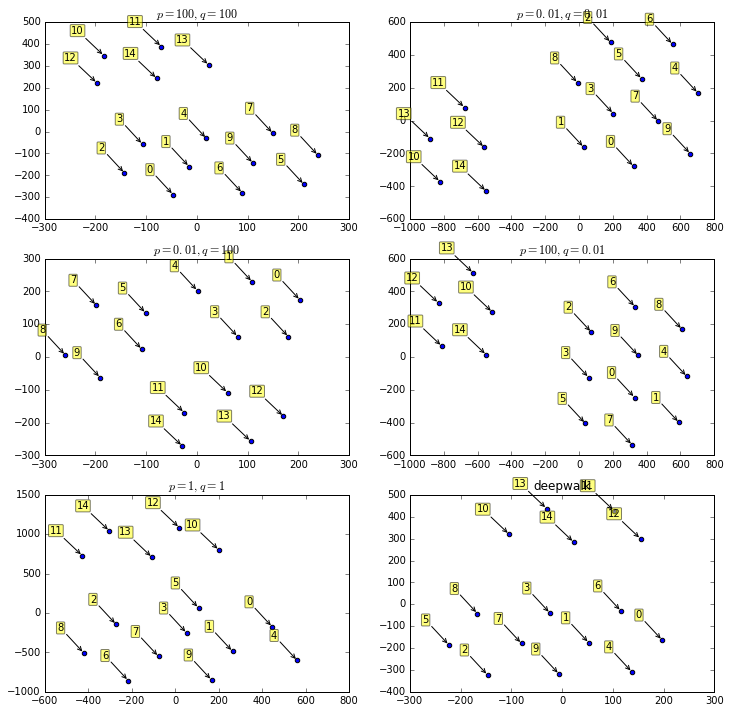

In [205]:
run_walk("star2", 20, 'tsne')

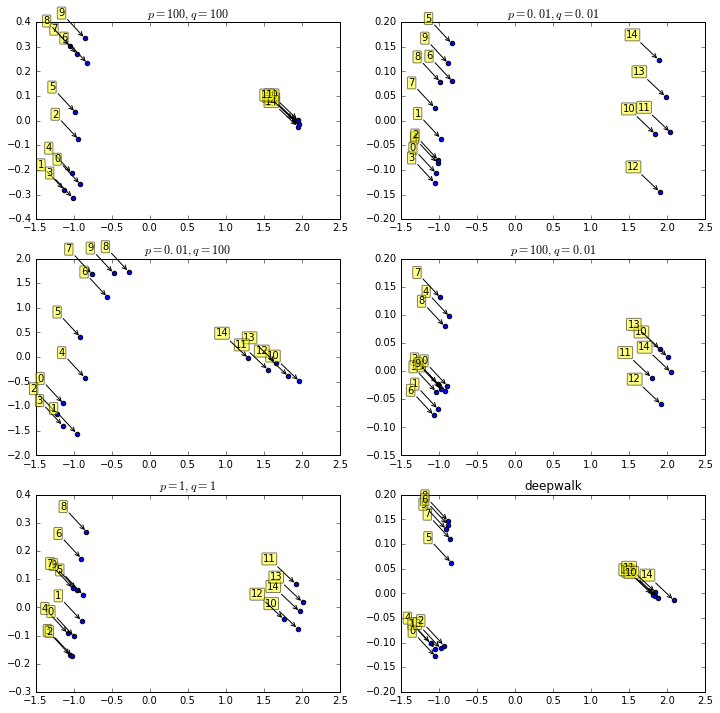

In [206]:
run_walk("star2", 100)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  15 ...
Mean value of sigma:  1.84269579817
Iteration  10 : error is  9.24183289071
Iteration  20 : error is  13.1650055877
Iteration  30 : error is  12.3672931539
Iteration  40 : error is  14.3625820118
Iteration  50 : error is  11.6697313732
Iteration  60 : error is  10.5762339988
Iteration  70 : error is  10.4783104706
Iteration  80 : error is  10.630676339
Iteration  90 : error is  10.6749797232
Iteration  100 : error is  13.6698913908
Iteration  110 : error is  1.18915663855
Iteration  120 : error is  0.928527813664
Iteration  130 : error is  0.754363798575
Iteration  140 : error is  0.618167130465
Iteration  150 : error is  0.512267252924
Iteration  160 : error is  0.47749657876
Iteration  170 : error is  0.458445217808
Iteration  180 : error is  0.441183250441
Iteration  190 : error is  0.426054038722
Iteration  200 : error is  0.411821052858
Iteration  210 : error is  0.40007

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  15 ...
Mean value of sigma:  2.23207160849
Iteration  10 : error is  9.88248253841
Iteration  20 : error is  11.1212465256
Iteration  30 : error is  12.7032802014
Iteration  40 : error is  12.0554494921
Iteration  50 : error is  12.4984790694
Iteration  60 : error is  11.9886042507
Iteration  70 : error is  13.1797996005
Iteration  80 : error is  13.7179636339
Iteration  90 : error is  13.7557174736
Iteration  100 : error is  16.9989645919
Iteration  110 : error is  1.31303318655
Iteration  120 : error is  1.19889235357
Iteration  130 : error is  1.11492180987
Iteration  140 : error is  1.04648358011
Iteration  150 : error is  0.976970809525
Iteration  160 : error is  0.914842466928
Iteration  170 : error is  0.862566733598
Iteration  180 : error is  0.820275202824
Iteration  190 : error is  0.786614017455
Iteration  200 : error is  0.75972228677
Iteration  210 : error is  0.7385629

Iteration  1000 : error is  0.20566339407
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  15 ...
Mean value of sigma:  1.83244731395
Iteration  10 : error is  9.92875715785
Iteration  20 : error is  20.4872921584
Iteration  30 : error is  9.58254477152
Iteration  40 : error is  9.43339108641
Iteration  50 : error is  9.79565801731
Iteration  60 : error is  11.0933934455
Iteration  70 : error is  12.2679140879
Iteration  80 : error is  12.5920278453
Iteration  90 : error is  15.2920204738
Iteration  100 : error is  17.4138161574
Iteration  110 : error is  1.72894228969
Iteration  120 : error is  1.3038457126
Iteration  130 : error is  1.1658345171
Iteration  140 : error is  1.04603058088
Iteration  150 : error is  0.936092522449
Iteration  160 : error is  0.852528932086
Iteration  170 : error is  0.779340549342
Iteration  180 : error is  0.708984532909
Iteration  190 : error is  0.643271828678
Iteration  200 : error is  0.58364241

Iteration  1000 : error is  0.205695665365


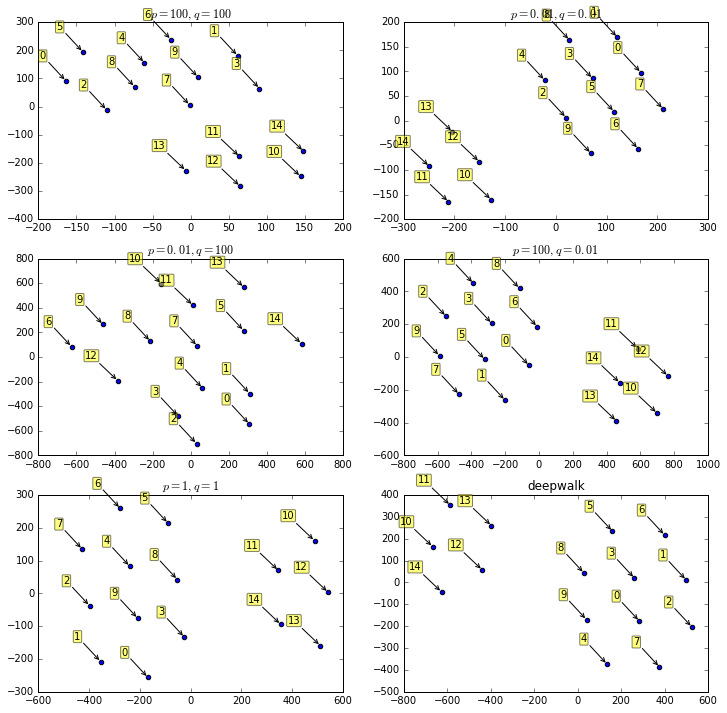

In [207]:
run_walk("star2", 100, 'tsne')